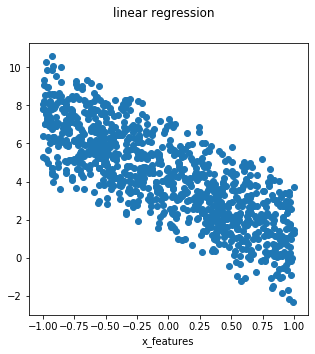

In [6]:
# coding=utf-8
import numpy as np
import tensorflow as tf
from tensorflow import keras

# 生成数据集 y = b + w*x
num_examples = 1000
true_w = tf.constant([2.0, -3.4, 1.6]) 
true_b = tf.constant(4.2)

x_features = None # shape=(num_examples, len(true_w))
y_labels = None


# 直接生成 tensor
with tf.device("CPU:0"): # InternalError: Blas GEMV launch failed
    true_w = tf.reshape(true_w, (len(true_w),1)) 
    x_features = tf.random.uniform(shape=(num_examples, len(true_w)), minval=-1, maxval=1) # 模拟归一化数据 （-1,1）可以拟合，（-100,100）loss爆炸
    y_labels = tf.matmul(x_features, true_w) + true_b
    y_labels = tf.random.normal(shape=y_labels.shape, mean=y_labels, stddev=0.001)
    # print(x_features,'\n', y_labels)


# 数据可视化
from matplotlib import pyplot as plt
plt.figure(figsize=(5,5))
plt.subplot(1,1,1)
x = np.array(x_features[:,1])
y = np.array(y_labels)
# z = np.array(y_examples)
# print(x, y)
# plt.plot(x, y, '-g')
plt.scatter(x, y)
# plt.plot(x, y, '-g', x, z, 'bo')
plt.suptitle('linear regression')
plt.xlabel('x_features')
plt.show()


In [32]:
# keras　实现

# 数据读取
# TODO: tf.Dataset 里各种 iterator 用法，读取csv,图像数据方法，keras.fit配合的方法如 ImageDataSet

from tensorflow import data as tfdata

batch_size = 5
dataset = tfdata.Dataset.from_tensor_slices((x_features, y_labels))

# shuffle的buffer_size要>=样本数
dataset = dataset.shuffle(buffer_size=num_examples)
dataset = dataset.batch(batch_size)

# data_iter = iter(dataset) # 只能遍历数据集一次
# for batch,(x, y) in enumerate(dataset):
#     print(batch, x, y)
#     break


# 模型定义
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import initializers as init

model = keras.Sequential()
print(len(true_w))
model.add(layers.Dense(units=1, use_bias=True ,kernel_initializer=init.RandomNormal(stddev=0.01)))
# 输出维度unit=1,即y的维度 dim(yi)*batch
# model.trainable_variables = dim(true_w)
# use_bias 会添加 dim(true_b)=1 个偏置参数


# 损失函数
# TODO: 自定义损失函数
from tensorflow import losses
loss = losses.MeanSquaredError()

# 优化器
from tensorflow import optimizers
trainer = optimizers.SGD(learning_rate=0.003)

# 训练
num_epochs = 5
with tf.device("CPU:0"):
    for epoch in range(1, num_epochs+1):
        for batch,(x, y) in enumerate(dataset):
            # print(x, y)
            # 记录动态图梯度
            with tf.GradientTape() as tape:
                loss_v = loss(model(x, training=True), y)
            # 执行tape.gradient获得动态图中各变量梯度，model.trainable_variables 找到需要更新的变量
            grads = tape.gradient(loss_v, model.trainable_variables)
            # print(grads)
            # print('\n\n',model.trainable_variables)
            # print(model(x))
            
            # 由梯度更新权重
            trainer.apply_gradients(zip(grads, model.trainable_variables))

        # 评估损失值
        loss_v = loss(model(x_features), y_labels)
        print('epoch:{} loss:{}'.format(epoch, tf.reduce_mean(loss_v)))
    
    print(true_w, w)
    print(true_b, b)



3
epoch:1 loss:4.222649097442627
epoch:2 loss:1.325326681137085
epoch:3 loss:0.548541247844696
epoch:4 loss:0.24568893015384674
epoch:5 loss:0.11211945861577988
tf.Tensor(
[[ 2. ]
 [-3.4]
 [ 1.6]], shape=(3, 1), dtype=float32) <tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 1.9999754],
       [-3.3998947],
       [ 1.5999954]], dtype=float32)>
tf.Tensor(4.2, shape=(), dtype=float32) <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.2001224], dtype=float32)>


In [30]:
# tf2　基础实现
# TODO: 封装成类

# 数据读取：　自定义　data_iter
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    tf.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = indices[i:min(i+batch_size, num_examples)]
        yield tf.gather(features, axis=0, indices=j), tf.gather(labels, axis=0, indices=j)


# 初始化参数模型
w = tf.Variable(tf.random.normal(shape=(len(true_w),1), stddev=0.01))
b = tf.Variable(tf.zeros(shape=(1,)))

# 定义模型
def linear_regression(x, w, b):
    return tf.matmul(x,w) + b

# 损失函数
def squared_loss(y_hat, y):
    # print('loss func:', y_hat, '\n', y)
    return (y_hat-tf.reshape(y, y_hat.shape))**2/2

# 优化器
def sgd(params, lr, batch_size, grads):
    '''
    mini-batch sgd: 计算梯度时，将整个batch的loss值的和用于计算（squared_loss得到的是batch_size个loss）
    如果不除以batch_size，batch越大，gradient值越大，
    '''
    for i, param in enumerate(params):
        param.assign_sub(lr*grads[i]/batch_size)

# 训练模型
lr = 0.03
num_epochs = 5
batch_size = 5
loss = squared_loss

for epoch in range(num_epochs):
    for x, y  in data_iter(batch_size, x_features,y_labels):
        with tf.GradientTape() as tape:
            tape.watch([w, b])
            l = loss(linear_regression(x,w,b), y)
            # print(l)
            
        grads = tape.gradient(l, [w,b])
        # print(grads,'\n')
        # break
        sgd([w,b], lr, batch_size, grads)
    loss_total = loss(linear_regression(x_features, w, b), y_labels)
    print('epoch %d, loss %f' % (epoch + 1, tf.reduce_mean(loss_total)))

print(true_w, w)
print(true_b, b)

# >>>
# epoch 1, loss 0.054966
# epoch 2, loss 0.001085
# epoch 3, loss 0.000022
# epoch 4, loss 0.000001
# epoch 5, loss 0.000001
# tf.Tensor(
# [[ 2. ]
#  [-3.4]
#  [ 1.6]], shape=(3, 1), dtype=float32) <tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
# array([[ 1.9999754],
#        [-3.3998947],
#        [ 1.5999954]], dtype=float32)>
# tf.Tensor(4.2, shape=(), dtype=float32) <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.2001224], dtype=float32)>



epoch 1, loss 0.054966
epoch 2, loss 0.001085
epoch 3, loss 0.000022
epoch 4, loss 0.000001
epoch 5, loss 0.000001
tf.Tensor(
[[ 2. ]
 [-3.4]
 [ 1.6]], shape=(3, 1), dtype=float32) <tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 1.9999754],
       [-3.3998947],
       [ 1.5999954]], dtype=float32)>
tf.Tensor(4.2, shape=(), dtype=float32) <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.2001224], dtype=float32)>


In [16]:
x = tf.constant(np.random.random(18).reshape(2,3,3))
print(x)

y = tf.gather(x, axis=1, indices=[0,1])
print(y)

tf.Tensor(
[[[0.41999495 0.52043167 0.19738202]
  [0.46788309 0.77243664 0.41093324]
  [0.74835129 0.94384473 0.16528463]]

 [[0.06885835 0.80335686 0.67737217]
  [0.29135583 0.05054375 0.17756607]
  [0.28744346 0.394279   0.56378402]]], shape=(2, 3, 3), dtype=float64)
tf.Tensor(
[[[0.41999495 0.52043167 0.19738202]
  [0.46788309 0.77243664 0.41093324]]

 [[0.06885835 0.80335686 0.67737217]
  [0.29135583 0.05054375 0.17756607]]], shape=(2, 2, 3), dtype=float64)
